In [1]:
using Pkg
Pkg.add("SpecialFunctions")
using SpecialFunctions
Pkg.add("LinearAlgebra")
using LinearAlgebra
Pkg.add("Plots")
using Plots

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [15]:

struct SOrbital
           x0::Float64
           y0::Float64
           z0::Float64
           alpha::Float64
    end
	
function STO(Z, x0, y0, z0)
       if Z == 1
    global s = [0.168856 0.444635; 0.623913 0.535328; 3.42525 0.154329];
        n = 3;
        global c1 = s[1,2];
        global c2 = s[2,2];
        global c3 = s[3,2];
        g1 = SOrbital(x0,y0,z0,s[1,1]);
        g2 = SOrbital(x0,y0,z0,s[2,1]);
        g3 = SOrbital(x0,y0,z0,s[3,1]);
    end
    if Z == 2
        global s = [0.164979 0.3046345422; 0.5892299 0.6553281423; 3.0522421 0.1543289673];
        n = 3;
        global c1 = s[1,2];
        global c2 = s[2,2];
        global c3 = s[3,2];
        g1 = SOrbital(x0,y0,z0,s[1,1]);
        g2 = SOrbital(x0,y0,z0,s[2,1]);
        g3 = SOrbital(x0,y0,z0,s[3,1]);
    end
    return g1, g2, g3, c1, c2, c3
end

## Overlap

function goverlap1D(x1, alpha1, x2, alpha2)
    p = alpha1 + alpha2
    q=(alpha1*alpha2)/p;
    P=(alpha1*x1 + alpha2*x2)/p;
    Q=x1-x2;
    KAB=exp(-q*Q^2);
return KAB
end

function goverlap(g1, g2)
    Ex = goverlap1D(g1.x0, g1.alpha, g2.x0, g2.alpha);
    Ey = goverlap1D(g1.y0, g1.alpha, g2.y0, g2.alpha);
    Ez = goverlap1D(g1.z0, g1.alpha, g2.z0, g2.alpha);
    s = Ex * Ey * Ez * sqrt(pi/(g1.alpha + g2.alpha))^3 * (2*g1.alpha/pi)^.75 * (2*g2.alpha/pi)^.75;
    return s
end

function Build_Overlap(basis)
nbasis = size(basis, 1)
S = zeros(nbasis, nbasis)
    for a in 1:nbasis
        for b in 1:nbasis
            for i in 1:3
                for j in 1:3
                     S[a,b] = S[a,b] + goverlap(basis[a][i], basis[b][j]) * basis[a][i+3] * basis[b][j+3];
                end
            end
        end
    end
    return S
end

##Kinetic 

function Build_Kinetic(basis)
nbasis = size(basis, 1)
T = zeros(nbasis, nbasis)
    for a in 1:nbasis
        for b in 1:nbasis
            for i in 1:3
                for j in 1:3
                
                    p = basis[a][i].alpha + basis[b][j].alpha;
                    Px = (basis[a][i].alpha * basis[a][i].x0 + basis[b][j].alpha * basis[b][j].x0) / p;
                    Py = (basis[a][i].alpha * basis[a][i].y0 + basis[b][j].alpha * basis[b][j].y0) / p;
                    Pz = (basis[a][i].alpha * basis[a][i].z0 + basis[b][j].alpha * basis[b][j].z0) / p;

                    T[a,b] = T[a,b] + 3*basis[b][j].alpha * goverlap(basis[a][i], basis[b][j]) * basis[a][i+3] * basis[b][j+3] -
                    2 * basis[b][j].alpha^2 * ((Px - basis[b][j].x0)^2 + 1/(2 * p)) * goverlap(basis[a][i], basis[b][j]) * basis[a][i+3] * basis[b][j+3] -
                    2 * basis[b][j].alpha^2 * ((Py - basis[b][j].y0)^2 + 1/(2 * p)) * goverlap(basis[a][i], basis[b][j]) * basis[a][i+3] * basis[b][j+3] -
                    2 * basis[b][j].alpha^2 * ((Pz - basis[b][j].z0)^2 + 1/(2 * p)) * goverlap(basis[a][i], basis[b][j]) * basis[a][i+3] * basis[b][j+3];
         
                end
            end
        end
    end     
    return T
end

## Coulomb Integrals

function Boys(x);
    if x == 0
        return 1
    else
        return (0.5*(pi/x)^0.5)*erf(x^0.5)
    end
end

function coulombg(g1, g2, x0, y0, z0);
a = g1.alpha;
b = g2.alpha;
p = a+b;
P = [a * g1.x0 + b * g2.x0, a * g1.y0 + b * g2.y0, a * g1.z0 + b * g2.z0]/p;
A = [x0, y0, z0];
RPA2 = sum((A - P) .^ 2);
    
Ex = goverlap1D(g1.x0,a,g2.x0,b);
Ey = goverlap1D(g1.y0,a,g2.y0,b);
Ez = goverlap1D(g1.z0,a,g2.z0,b);

V = -1 * 2 * pi/p * Boys(p * RPA2) * (2 * a/pi)^0.75 * (2 * b/pi)^0.75 * Ex * Ey * Ez;    
    return V
end

function Build_Nuclear_Attraction(basis);
    
nbasis = size(basis, 1)
y = size(basis, 1)
VAB = zeros(nbasis, nbasis, y)

    for c in 1:size(basis, 1)
        for a in 1:nbasis
            for b in 1:nbasis
                for i in 1:3
                    for j in 1:3
                       VAB[a,b,c] = VAB[a,b,c] + coulombg(basis[a][i], basis[b][j], basis[c][i].x0, basis[c][i].y0, basis[c][i].z0) * basis[a][i+3] * basis[b][j+3];  
                    end
                end
            end
        end
    end
return VAB
end


##electron-electron repulsion

function Build_Electron_Repulsion(basis);
nbasis = size(basis, 1)
gabcd = zeros(nbasis,nbasis,nbasis,nbasis);
for a = 1:nbasis
    for na = 1:0.5*size(basis[a], 1)
        aa = basis[a][na].alpha;
        for b = 1:nbasis
            for nb = 1:0.5*size(basis[b], 1)
                ab = basis[b][nb].alpha;
                p = aa+ab;
                Px = (basis[a][na].x0 * aa + basis[b][nb].x0 * ab)/p;
                Py = (basis[a][na].y0 * aa + basis[b][nb].y0 * ab)/p;
                Pz = (basis[a][na].z0 * aa + basis[b][nb].z0 * ab)/p;
                EabX = goverlap1D(basis[a][na].x0, aa, basis[b][nb].x0, ab);
                EabY = goverlap1D(basis[a][na].y0, aa, basis[b][nb].y0, ab);
                EabZ = goverlap1D(basis[a][na].z0, aa, basis[b][nb].z0, ab);
                A_AB = EabX * EabY * EabZ * basis[a][na+3] * basis[b][nb+3] * (2*basis[a][na].alpha/pi)^.75 * (2*basis[b][nb].alpha/pi)^.75;
                for c = 1:nbasis
                    for nc = 1:0.5*size(basis[c], 1)
                        ac = basis[c][nc].alpha;
                        for d = 1:nbasis
                            for nd = 1:0.5*size(basis[d], 1)
                                ad = basis[d][nd].alpha;
                                pp = ac + ad;
                                PPx = (basis[c][nc].x0*ac + basis[d][nd].x0*ad)/pp;
                                PPy = (basis[c][nc].y0*ac + basis[d][nd].y0*ad)/pp;
                                PPz = (basis[c][nc].z0*ac + basis[d][nd].z0*ad)/pp;
                                EcdX = goverlap1D(basis[c][nc].x0, ac, basis[d][nd].x0, ad);
                                EcdY = goverlap1D(basis[c][nc].y0, ac, basis[d][nd].y0, ad);
                                EcdZ = goverlap1D(basis[c][nc].z0, ac, basis[d][nd].z0, ad);
                                A_CD = EcdX * EcdY * EcdZ * (2*basis[d][nd].alpha/pi)^.75 * (2*basis[c][nc].alpha/pi)^.75 * basis[c][nc+3] * basis[d][nd+3];
                                RPPP2 = (Px-PPx)^2 + (Py-PPy)^2 + (Pz-PPz)^2;
                                alpha = pp*p/(pp+p);
                                gabcd[a,b,c,d] = gabcd[a,b,c,d] + A_AB * A_CD * Boys(alpha*RPPP2) * 2*pi^2.5/(p*pp*sqrt(p+pp));
                            end
                        end
                    end
                end
            end
        end
    end
end
    return gabcd
end

#################################################################################


function Build_Density_uhf(C, N);
nb = size(C, 1);
D = zeros(nb,nb);
for n = 1:nb
    for m = 1:nb
        for i = 1:1    #should be 1:N/2 but julia makes it float instead of int and it becomes a problem in the next line
            D[n,m] = D[n,m] + (C[n,i] * C[m,i]);
        end
    end
 end
    return D
end

function Build_Coulomb_Exchange_uhf(Done, Dfour, Gabcd);
nb = size(Done,1);
Gr = zeros(2, 2);
Gu = zeros(2, 2);
    
for b = 1:nb
    for d = 1:nb
        for a = 1:nb
            for c = 1:nb
               Gr[b,d] = Gr[b,d] + (Done[a,c] + Dfour[a,c]) * Gabcd[a, b, c, d] - Done[a,c] * Gabcd[a, b, d, c];
            end
        end
    end
end

for b = 1:nb
    for d = 1:nb
        for a = 1:nb
            for c = 1:nb
               Gu[b,d] = Gu[b,d] + (Done[a,c] + Dfour[a,c]) * Gabcd[a, b, c, d] - Dfour[a,c] * Gabcd[a, b, d, c];
            end
        end
    end
end
    
    return Gr, Gu
end


function Fock_Energy_uhf(Done, Dtwo, H0, Fone, Ftwo)
nb = size(Done,1);
E = 0;
    for m = 1:nb
        for n in 1:nb
        E = E + 0.5 * (((Done[m,n] + Dtwo[m,n]) * H0[n,m]) + (Done[m,n] * Fone[n,m]) + (Dtwo[m,n] * Ftwo[n,m])); 
        end
    end
return E
end
                           
function unrestricted_twobody(Cone, Ctwo, Gabcd);
nb = size(Cone, 1)
twobody = zeros(nb,nb,nb,nb)
for i in 1:nb
    for j in 1:nb
        for k in 1:nb
            for l in 1:nb
               twobody[i,j,k,l] = Cone[1,i]*Cone[1,j]*Ctwo[1,k]*Ctwo[1,l]*Gabcd[1,1,1,1] + Cone[1,i]*Cone[1,j]*Ctwo[1,k]*Ctwo[2,l]*Gabcd[1,1,1,2] + Cone[1,i]*Cone[1,j]*Ctwo[2,k]*Ctwo[1,l]*Gabcd[1,1,2,1] + Cone[1,i]*Cone[1,j]*Ctwo[2,k]*Ctwo[2,l]*Gabcd[1,1,2,2] + 
                                  Cone[1,i]*Cone[2,j]*Ctwo[1,k]*Ctwo[1,l]*Gabcd[1,2,1,1] + Cone[1,i]*Cone[2,j]*Ctwo[1,k]*Ctwo[2,l]*Gabcd[1,2,1,2] + Cone[1,i]*Cone[2,j]*Ctwo[2,k]*Ctwo[1,l]*Gabcd[1,2,2,1] + Cone[1,i]*Cone[2,j]*Ctwo[2,k]*Ctwo[2,l]*Gabcd[1,2,2,2] + 
                                  Cone[2,i]*Cone[1,j]*Ctwo[1,k]*Ctwo[1,l]*Gabcd[2,1,1,1] + Cone[2,i]*Cone[1,j]*Ctwo[1,k]*Ctwo[2,l]*Gabcd[2,1,1,2] + Cone[2,i]*Cone[1,j]*Ctwo[2,k]*Ctwo[1,l]*Gabcd[2,1,2,1] + Cone[2,i]*Cone[1,j]*Ctwo[2,k]*Ctwo[2,l]*Gabcd[2,1,2,2] + 
                                  Cone[2,i]*Cone[2,j]*Ctwo[1,k]*Ctwo[1,l]*Gabcd[2,2,1,1] + Cone[2,i]*Cone[2,j]*Ctwo[1,k]*Ctwo[2,l]*Gabcd[2,2,1,2] + Cone[2,i]*Cone[2,j]*Ctwo[2,k]*Ctwo[1,l]*Gabcd[2,2,2,1] + Cone[2,i]*Cone[2,j]*Ctwo[2,k]*Ctwo[2,l]*Gabcd[2,2,2,2];
            end
        end
    end
end
return twobody
end

#######################################################################

function Build_Density_rhf(C);
nb = size(C, 1);
D = zeros(nb,nb);
for n = 1:nb
    for m = 1:nb
        for i in 1:1
            D[n,m] = D[n,m] + 2 * C[n,i] * C[m,i];
        end
    end
 end
    return D
end

function Build_Coulomb_Exchange_rhf(D, Gabcd);
nb = size(D,1);
G = zeros(nb,nb);
for b = 1:nb
    for d = 1:nb
        for a = 1:nb
            for c = 1:nb
                G[b,d] = G[b,d] + D[a,c] * (Gabcd[a, b, c, d] - 0.5 * Gabcd[a, b, d, c]);
            end
        end
    end
end
    return G
end

function Fock_Energy_rhf(D, H0, F)

nb = size(D,1);
E = 0;
for n = 1:nb
    for m = 1:nb
        E = E + 0.5 * D[n,m] * (H0[m,n] + F[m,n]);
    end
end
return E
end

function hij(C, H0)
nb = size(C, 1)
hij = zeros(nb, nb)
for i in 1:nb
    for j in 1:nb
        hij[i, j] =  C[1,i] * C[1,j] * H0[1,1] + C[1,i] * C[2,j] * H0[1,2] + C[2,i] * C[1,j] * H0[2,1] + C[2,i] * C[2,j] * H0[2,2] 
    end
end
return hij
end 

function twobody(C, Gabcd)
nb = size(C, 1)
twobody = zeros(nb,nb,nb,nb)
for i in 1:nb
    for j in 1:nb
        for k in 1:nb
            for l in 1:nb
                twobody[i,j,k,l] = C[1,i]*C[1,j]*C[1,k]*C[1,l]*Gabcd[1,1,1,1] + C[1,i]*C[1,j]*C[1,k]*C[2,l]*Gabcd[1,1,1,2] + C[1,i]*C[1,j]*C[2,k]*C[1,l]*Gabcd[1,1,2,1] + C[1,i]*C[1,j]*C[2,k]*C[2,l]*Gabcd[1,1,2,2] + 
                                   C[1,i]*C[2,j]*C[1,k]*C[1,l]*Gabcd[1,2,1,1] + C[1,i]*C[2,j]*C[1,k]*C[2,l]*Gabcd[1,2,1,2] + C[1,i]*C[2,j]*C[2,k]*C[1,l]*Gabcd[1,2,2,1] + C[1,i]*C[2,j]*C[2,k]*C[2,l]*Gabcd[1,2,2,2] + 
                                   C[2,i]*C[1,j]*C[1,k]*C[1,l]*Gabcd[2,1,1,1] + C[2,i]*C[1,j]*C[1,k]*C[2,l]*Gabcd[2,1,1,2] + C[2,i]*C[1,j]*C[2,k]*C[1,l]*Gabcd[2,1,2,1] + C[2,i]*C[1,j]*C[2,k]*C[2,l]*Gabcd[2,1,2,2] + 
                                   C[2,i]*C[2,j]*C[1,k]*C[1,l]*Gabcd[2,2,1,1] + C[2,i]*C[2,j]*C[1,k]*C[2,l]*Gabcd[2,2,1,2] + C[2,i]*C[2,j]*C[2,k]*C[1,l]*Gabcd[2,2,2,1] + C[2,i]*C[2,j]*C[2,k]*C[2,l]*Gabcd[2,2,2,2];
            end
        end
    end
end
return twobody
end                     

function SCF_rhf(R)
    
A = STO(1, 0.0, 0.0, 0.0)
B = STO(1, 0.0, 0.0, R)
basis = [A, B];
S = Build_Overlap(basis);
T = Build_Kinetic(basis);
V1 = Build_Nuclear_Attraction(basis)[:, :, 1];
V2 = Build_Nuclear_Attraction(basis)[:, :, 2];
H0 = T + V1 + V2;
Gabcd = Build_Electron_Repulsion(basis);
maxcycle = 10;
converged = 1;
ncycle = 1;
       
#Eg = zeros(maxcycle, 1); 
Et = zeros(maxcycle, 1);  
v = eigvecs(S);
d = Diagonal(eigvals(S));
X = inv(v) * d^(-0.5) * v
nb = size(S,1);
    
C = zeros(2, 2)
D = Build_Density_rhf(C);
    
G = Build_Coulomb_Exchange_rhf(D, Gabcd);  
Fnew = H0 + G;
    
    while ncycle < maxcycle
        ncycle = ncycle + 1;
        Fprime = inv(X) * Fnew * X
        Cprime = eigvecs(Fprime);
        C = X * Cprime;
        D = Build_Density_rhf(C);
        H = hij(C, H0)
        Gijkl = twobody(C, Gabcd)
        G = Build_Coulomb_Exchange_rhf(D, Gabcd)
        Fnew = H0 + G
        #Eg[ncycle] = 2 * H[1,1] + Gijkl[1, 1, 1, 1]
        Et[ncycle] = Fock_Energy_rhf(D, H0, Fnew)
        
end
return (Et[ncycle]+1/R)
end

function SCF_uhf(R)
    
A = STO(1, 0.0, 0.0, R)
B = STO(1, 0.0, 0.0, 0.0)
basis = [A, B];
    
Na = 1;
Nb = 1;
N = 2;

S = Build_Overlap(basis);
T = Build_Kinetic(basis);
V1 = Build_Nuclear_Attraction(basis)[:, :, 1];
V2 = Build_Nuclear_Attraction(basis)[:, :, 2];
H0 = T + V1 + V2

Gabcd = Build_Electron_Repulsion(basis)
    
maxcycle = 10;
converged = 1;
ncycle = 1;
    
#Eg = zeros(maxcycle, 1);
Et = zeros(maxcycle, 1);
    
v = eigvecs(S);    
d = Diagonal(eigvals(S));
X = inv(v) * d^(-0.5) * v;
nb = size(S,1);

Cone = [0.0 0.0; 0.0 0.0]
Cfour = [1.0 0.0; 0.0 1.0]

Donenew = Build_Density_uhf(Cone, N)
Dfournew = Build_Density_uhf(Cfour, N)
Dtotalnew = Donenew + Dfournew
Dsnew = Donenew - Dfournew
    
G1 = Build_Coulomb_Exchange_uhf(Donenew, Dfournew, Gabcd)[1]
G4 = Build_Coulomb_Exchange_uhf(Donenew, Dfournew, Gabcd)[2]

    
Fnew = zeros(2*nb,2*nb)
for a in 1:2
    for b in 1:2
        Fnew[a,b] = H0[a,b] + G1[a,b]
    end
end


for a in 1:2
    for b in 3:4
        Fnew[a,b] = 0
    end
end

for a in 3:4
    for b in 1:2
        Fnew[a,b] = 0
    end
end

for a in 3:4
    for b in 3:4
        Fnew[a,b] = H0[a-2,b-2] + G4[a-2,b-2]
    end
end
    

while ncycle < maxcycle 
       
        
ncycle = ncycle + 1;
        
Gone = zeros(2, 2)
for i in 1:2
    for j in 1:2
        Gone[i, j] = Fnew[i, j]
    end
end

Gtwo = zeros(2, 2)
for i in 1:2
    for j in 1:2
        Gtwo[i, j] = Fnew[i, j+2]
    end
end

Gthree = zeros(2, 2)
for i in 1:2
    for j in 1:2
        Gthree[i, j] = Fnew[i+2, j]
    end
end

Gfour = zeros(2, 2)
for i in 1:2
    for j in 1:2
        Gfour[i, j] = Fnew[i+2, j+2]
    end
end

        
Foneprime = inv(X) * Gone * X
Coneprime = eigvecs(Foneprime)
Conenew = X * Coneprime

Ffourprime = inv(X) * Gfour * X
Cfourprime = eigvecs(Ffourprime)
Cfournew = X * Cfourprime

Donenew = Build_Density_uhf(Conenew,N);
Dtwonew = [0 0; 0 0]
Dthreenew = [0 0; 0 0]
Dfournew = Build_Density_uhf(Cfournew,N);

Dtotalnew = Donenew + Dfournew
Dsnew = Donenew - Dfournew

global Dnew = [Donenew Dtwonew; Dthreenew Dfournew]

G1 = Build_Coulomb_Exchange_uhf(Donenew,Dfournew, Gabcd)[1]
G4 = Build_Coulomb_Exchange_uhf(Donenew,Dfournew, Gabcd)[2]

    
Fnew = zeros(2*nb, 2*nb)
    
for a in 1:2
    for b in 1:2
        Fnew[a,b] = H0[a,b] + G1[a,b] 
    end
end


for a in 1:2
    for b in 3:4
         Fnew[a,b] = 0
    end
end

for a in 3:4
    for b in 1:2
        Fnew[a,b] = 0
    end
end

for a in 3:4
    for b in 3:4
        Fnew[a,b] = H0[a-2,b-2] + G4[a-2,b-2]
    end
end
    
Fonenew = zeros(nb, nb)
Ffournew = zeros(nb, nb)
        
for a in 1:2
    for b in 1:2
        Fonenew[a,b] = Fnew[a,b] 
    end
end

for a in 1:2
    for b in 1:2
        Ffournew[a,b] = Fnew[a+2, b+2]
    end
end        
        
    H1 = hij(Conenew, H0)
    H2 = hij(Cfournew, H0)
    Gijkl = unrestricted_twobody(Conenew, Cfournew, Gabcd);
    #Eg[ncycle] = H2[1,1] + H1[1,1] + Gijkl[1, 1, 1, 1]
    Et[ncycle] = Fock_Energy_uhf(Donenew, Dfournew, H0, Fonenew, Ffournew)
    
end

return (Et[ncycle] + 1/R)
end


SCF_uhf (generic function with 1 method)

In [16]:
SCF_rhf(1.4)
SCF_uhf(1.4)

-1.1167143213519295

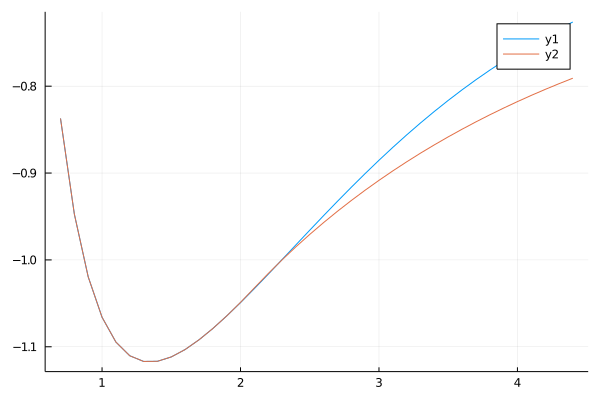

In [26]:
R = [i for i in 0.7:0.1:4.4]
rhf = [SCF_rhf(i) for i in 0.7:0.1:4.4]
uhf = [SCF_uhf(i) for i in 0.7:0.1:4.4]

plot(R, rhf)
plot!(R, uhf)